#### Import Libraries

In [1]:
import cv2                 
import numpy as np         
import os                  
from random import shuffle
import tensorflow as tf 
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import glob as gb
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

#### Setting the dataset path

In [2]:
#read DataSet
TrainImage="./Dataset/"

print(TrainImage)

./Dataset/


In [3]:
#to get all image names in train file
Pneumonaimages = os.listdir(TrainImage + "/PNEUMONIA")
Normalimages = os.listdir(TrainImage + "/NORMAL")
COVID19images = os.listdir(TrainImage + "/COVID19")

#### Explore the Data

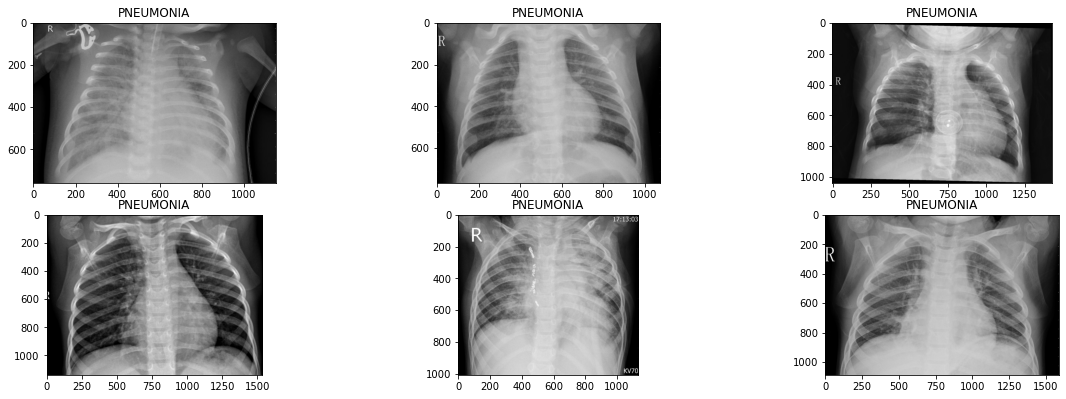

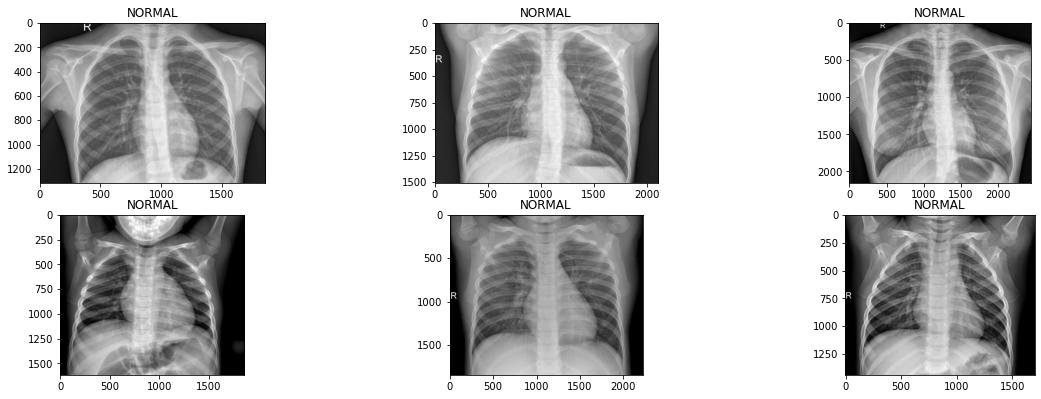

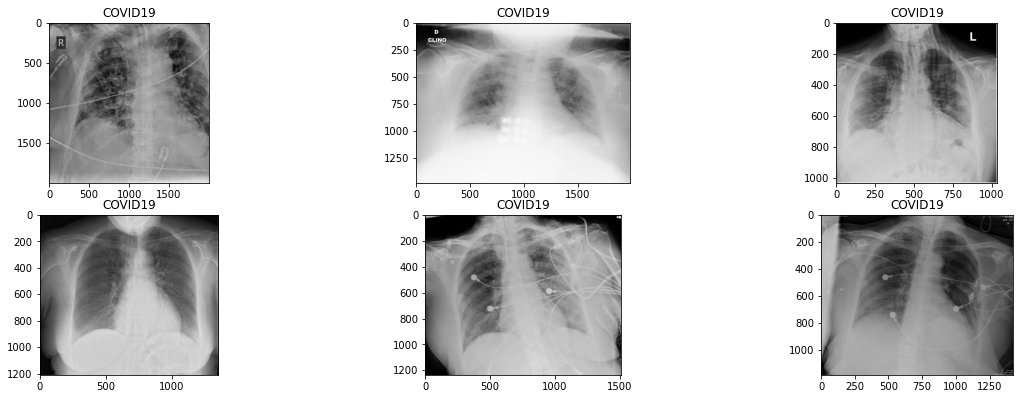

In [4]:
#plot to show the size of some image
#plot PNEUMONIA
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrainImage + "/PNEUMONIA",Pneumonaimages[i])),cmap='gray')
    plt.title("PNEUMONIA")
    
plt.show()
#plot NORMAL
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrainImage + "/NORMAL",Normalimages[i])),cmap='gray')
    plt.title("NORMAL")

plt.show()
#plot 
plt.figure(figsize=(20,10))
for i in range(6):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join(TrainImage + "/COVID19",COVID19images[i])),cmap='gray')
    plt.title("COVID19")

#### ImageDataGenerator (DataAugmentation )

In [6]:
Labels={'COVID19':0,'NORMAL':1 ,'PNEUMONIA':2 }

# convert label to code
def getCode(label):
    return Labels[label]


# convert code to label 
def getLabel(n):
    for x,c in Labels.items():
        if n==c:
            return x
        
               
#Test        
print(getCode('COVID19'))
print(getLabel(1))

0
NORMAL


#### Load Data

In [8]:
#Reading image data
import glob as gb
import cv2  
sizeImage=300 # to resize the all image as same size

#to read all images from directory
def getData(Dir,sizeImage):
    X=[]
    y=[]
    for folder in  os.listdir(Dir) : #to get the file name 
        files = gb.glob(pathname= str( Dir  +"/" +folder+ '//*.jpg' )) # to get the images
        for file in files:
                picture=cv2.imread(file) #  or plt.imread(file)
                imageArray=cv2.resize(picture,(sizeImage,sizeImage))
                X.append(list(imageArray))
                y.append(getCode(folder))
    X=np.array(X)
    y=np.array(y)
    return X,y

In [9]:
#get train data
X_train, y_train = getData(TrainImage,sizeImage)

In [10]:
print("X_train Shape        ",X_train.shape)

X_train Shape         (6432, 300, 300, 3)


In [11]:
# #Convert y_train to categorical
y_train=to_categorical(y_train,3)
print("y_train ",y_train.shape)

y_train  (6432, 3)


In [12]:
train_datagen = ImageDataGenerator(
      samplewise_center=True,
      samplewise_std_normalization= True,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      fill_mode='nearest'
                                  )

#### Build Model

In [13]:
#load weight
Network_Weight="./DenseNet-BC-121-32-no-top.h5"
print(Network_Weight)

./DenseNet-BC-121-32-no-top.h5


In [14]:
from tensorflow.keras.applications.densenet import DenseNet121
pre_trained_model = DenseNet121(input_shape = (sizeImage, sizeImage, 3), 
                                include_top = False, 
                                weights = None)
pre_trained_model.load_weights(Network_Weight)
for layer in pre_trained_model.layers:
    layer.trainable = False  #to make the layers to Freeze Weights

In [15]:
from sklearn.metrics import roc_auc_score


In [16]:
from tensorflow.keras import Model


x = tf.keras.layers.Flatten()(pre_trained_model.output)

#Full Connected Layers
x = tf.keras.layers.Dense(512, activation='relu')(x)
#Add dropout to avoid Overfit
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
#Add dropout to avoid Overfit
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)

x=tf.keras.layers.Dense(3 , activation='sigmoid')(x)   

model = Model( pre_trained_model.input, x) 

# print(model.summary())
model.compile(optimizer='adam', loss="binary_crossentropy",metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
                                                                    

#### K-fold Cross Validation

In [17]:
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from sklearn.model_selection import KFold

# K-fold Cross Validation model evaluation
num_folds = 5
fold_no = 1
epochs = 20
acc_per_fold = []
loss_per_fold = []

kfold = KFold(n_splits=num_folds, shuffle=True, random_state=None)

import numpy as np
from sklearn.model_selection import KFold

In [19]:
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

filepath="transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

C:\Users\supriti.ghosh\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
20/20 [==============================] - 398s 19s/step - loss: 3.7317 - accuracy: 0.5064 - auc: 0.6535
Epoch 2/20
20/20 [==============================] - 379s 19s/step - loss: 0.5338 - accuracy: 0.7148 - auc: 0.8619
Epoch 3/20
20/20 [==============================] - 378s 19s/step - loss: 0.3023 - accuracy: 0.8234 - auc: 0.9378
Epoch 4/20
20/20 [==============================] - 376s 19s/step - loss: 0.2435 - accuracy: 0.8698 - auc: 0.9616
Epoch 5/20
20/20 [==============================] - 381s 19s/step - loss: 0.1835 - accuracy: 0.9049 - auc: 0.9786
Epoch 6/20
20/20 [==============================] - 374s 18s/step - loss: 0.1758 - accuracy: 0.9148 - auc: 0.9802
Epoch 7/20
20/20 [==============================] - 371s 18s/step - loss: 0.1484 - accuracy: 0.9121 - auc: 0.9850
Epoch 8/20
20/20 [==============================] - 368s 18s/step - loss: 0.1242 - accuracy: 0.9327 - auc: 0.9892
Epoch 9/20
20/20 [==============================] - 368s 18s/step - loss: 0.1419 - accur

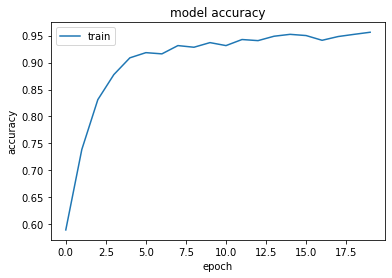

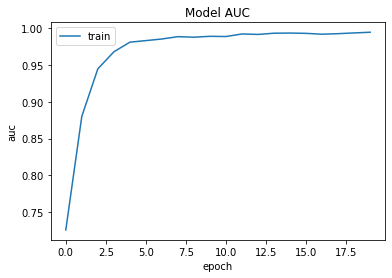

26/26 [==============================] - 98s 4s/step - loss: 0.0878 - accuracy: 0.9580 - auc: 0.9941
Score for fold 1: loss of 0.08779821544885635; accuracy of 95.80419659614563%; auc of 0.9940529465675354
Epoch 1/20
20/20 [==============================] - 490s 19s/step - loss: 0.0971 - accuracy: 0.9521 - auc: 0.9927
Epoch 2/20
20/20 [==============================] - 376s 19s/step - loss: 0.0834 - accuracy: 0.9579 - auc: 0.9941
Epoch 3/20
20/20 [==============================] - 374s 18s/step - loss: 0.0785 - accuracy: 0.9583 - auc: 0.9949
Epoch 4/20
20/20 [==============================] - 374s 18s/step - loss: 0.0765 - accuracy: 0.9581 - auc: 0.9954
Epoch 5/20
20/20 [==============================] - 375s 19s/step - loss: 0.0739 - accuracy: 0.9632 - auc: 0.9957
Epoch 6/20
20/20 [==============================] - 373s 18s/step - loss: 0.0828 - accuracy: 0.9560 - auc: 0.9944
Epoch 7/20
20/20 [==============================] - 375s 19s/step - loss: 0.0789 - accuracy: 0.9560 - auc: 0.9

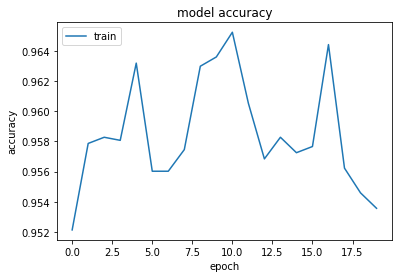

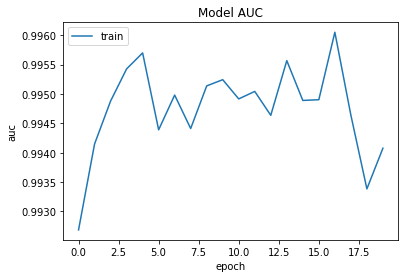

26/26 [==============================] - 100s 4s/step - loss: 0.0832 - accuracy: 0.9619 - auc: 0.9953
Score for fold 2: loss of 0.08315850049257278; accuracy of 96.19269371032715%; auc of 0.9953027963638306
Epoch 1/20
20/20 [==============================] - 558s 20s/step - loss: 0.0815 - accuracy: 0.9591 - auc: 0.9945
Epoch 2/20
20/20 [==============================] - 374s 18s/step - loss: 0.0698 - accuracy: 0.9622 - auc: 0.9957
Epoch 3/20
20/20 [==============================] - 370s 18s/step - loss: 0.0842 - accuracy: 0.9560 - auc: 0.9945
Epoch 4/20
20/20 [==============================] - 371s 18s/step - loss: 0.0710 - accuracy: 0.9616 - auc: 0.9961
Epoch 5/20
20/20 [==============================] - 368s 19s/step - loss: 0.0728 - accuracy: 0.9605 - auc: 0.9957
Epoch 6/20
20/20 [==============================] - 371s 18s/step - loss: 0.0683 - accuracy: 0.9632 - auc: 0.9960
Epoch 7/20
20/20 [==============================] - 371s 18s/step - loss: 0.0615 - accuracy: 0.9685 - auc: 0.

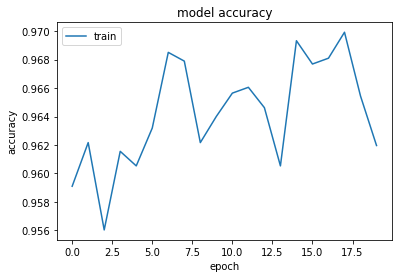

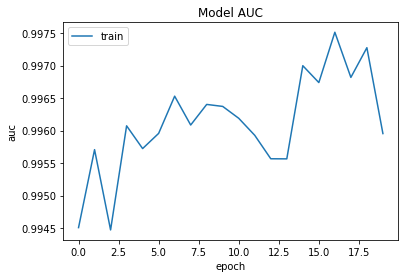

26/26 [==============================] - 101s 4s/step - loss: 0.0617 - accuracy: 0.9782 - auc: 0.9984
Score for fold 3: loss of 0.06169607862830162; accuracy of 97.82270789146423%; auc of 0.9983510375022888
Epoch 1/20
20/20 [==============================] - 451s 19s/step - loss: 0.0623 - accuracy: 0.9648 - auc: 0.9965
Epoch 2/20
20/20 [==============================] - 379s 19s/step - loss: 0.0578 - accuracy: 0.9671 - auc: 0.9972
Epoch 3/20
20/20 [==============================] - 375s 20s/step - loss: 0.0713 - accuracy: 0.9656 - auc: 0.9957
Epoch 4/20
20/20 [==============================] - 371s 18s/step - loss: 0.0633 - accuracy: 0.9687 - auc: 0.9964
Epoch 5/20
20/20 [==============================] - 371s 18s/step - loss: 0.0713 - accuracy: 0.9613 - auc: 0.9956
Epoch 6/20
20/20 [==============================] - 372s 18s/step - loss: 0.0608 - accuracy: 0.9663 - auc: 0.9968
Epoch 7/20
20/20 [==============================] - 369s 18s/step - loss: 0.0675 - accuracy: 0.9642 - auc: 0.

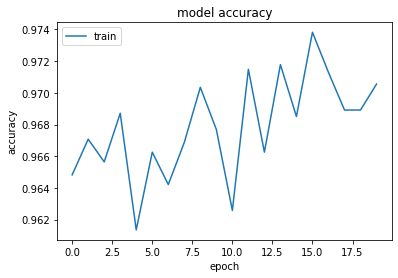

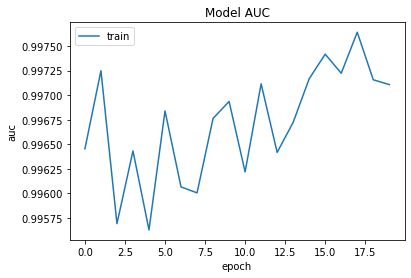

26/26 [==============================] - 99s 4s/step - loss: 0.0527 - accuracy: 0.9712 - auc: 0.9982
Score for fold 4: loss of 0.052655380219221115; accuracy of 97.12285995483398%; auc of 0.9982485175132751
Epoch 1/20
20/20 [==============================] - 408s 19s/step - loss: 0.0602 - accuracy: 0.9685 - auc: 0.9969
Epoch 2/20
20/20 [==============================] - 375s 19s/step - loss: 0.0576 - accuracy: 0.9701 - auc: 0.9974
Epoch 3/20
20/20 [==============================] - 388s 19s/step - loss: 0.0613 - accuracy: 0.9654 - auc: 0.9966
Epoch 4/20
20/20 [==============================] - 390s 19s/step - loss: 0.0563 - accuracy: 0.9701 - auc: 0.9972
Epoch 5/20
20/20 [==============================] - 372s 19s/step - loss: 0.0547 - accuracy: 0.9728 - auc: 0.9974
Epoch 6/20
20/20 [==============================] - 374s 18s/step - loss: 0.0453 - accuracy: 0.9759 - auc: 0.9978
Epoch 7/20
20/20 [==============================] - 372s 18s/step - loss: 0.0563 - accuracy: 0.9703 - auc: 0.

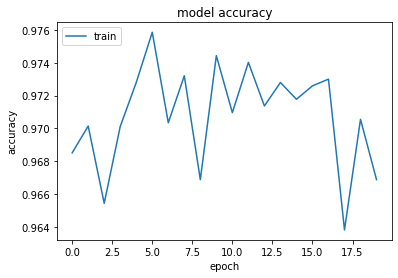

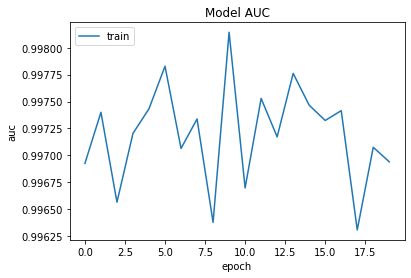

26/26 [==============================] - 100s 4s/step - loss: 0.0588 - accuracy: 0.9689 - auc: 0.9983
Score for fold 5: loss of 0.058763470500707626; accuracy of 96.88957929611206%; auc of 0.9982690215110779


In [20]:
score_list = []

for train, test in kfold.split(X_train, y_train):
    
    train_generator =train_datagen.flow(
         X_train[train], y_train[train],
         batch_size= 256
    )

    test_generator =train_datagen.flow(
         X_train[test], y_train[test],
         batch_size= 50
    )  

    history = model.fit_generator(train_generator,steps_per_epoch=20,callbacks=[lr_reduce,checkpoint] ,
             epochs=epochs)


    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['auc'])
    plt.title('Model AUC')
    plt.ylabel('auc')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    
    # Generate generalization metrics
    scores = model.evaluate(test_generator)
    score_list.append(scores)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%; {model.metrics_names[2]} of {scores[2]}')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    fold_no = fold_no + 1
 


In [21]:
for s in score_list:
    print(s[1]*100)

95.80419659614563
96.19269371032715
97.82270789146423
97.12285995483398
96.88957929611206
